# **AISE 4010 - Group 5 Term Project**


---

#

This notebook holds the code for our group project based on traffic based time-series prediction.

We will be using this dataset for analysis of traffic flow, and primarily trying to  accurately forecast future traffic flows. This forecasting analysis can be further used to aid in navigation systems such as google-maps, can be used to determine the typical time of rush hour, the difference between regular and rush hour traffic, and also be used for congestion analysis in future urban planning.

**Group Members:**
- Arnav Goyal
- Adil Virk
- Cristian Camilo Forero Duenas
- Tobechukwu Tony Uche-Anumba

The dataset can be found at this link
- https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset?resource=download

To run this notebook download this as a zip, and place the 'traffic.csv' file into the session's runtime.

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.0 MB/s eta 0:00:00


In [2]:
import os, sys, re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, GlobalMaxPool1D, Dense, Concatenate
import keras_tuner as kt

print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Part 1: Exploratory Data Analysis (EDA)

Here we will understand the dataset, its features, and perform seasonality, trend, and residual decomposition to figure out the key metrics of the data such that we can architect a model for accurate and general time-series prediction.

## The Dataset

Here we can see that the dataset comprises of 4 features:
- DateTime
- Junction
- Vehicles
- ID

The most Important features are: `DateTime`, which we will use as an index, `Vehicles` which represent the variable we are trying to forecast, and `Junction` which tells us which physical sensor has made the observation.

Before we begin training a DL Model on this data its crucial to separate the Data by Junction, This means we can train on some of the junction data, and evaluate on some of the other junction data to prove our model is able generalize well for traffic data, as opposed to training/testing over a single junction.

We can see that this Dataset features 4 different junctions with hourly recordings over varied timeframes. We must keep this in mind when progressing further with this project.

As for what we see and expect here, we can see that the data follows a roughly weekly period, and a daily period as well. Traffic is much higher on weekdays, and much lower on weekends this is evident due to the 5 big spikes, followed by 2 lower spikes. The daily period is probably due to the rush hour traffic. Howver after examining the actual plot, it seems that the weekly period is much more significant, as daily there doesnt seem to be an overall spike, its more-so consistently increasing traffic.

In [3]:
### BASIC PREPROCESSING

df_raw = pd.read_csv('traffic.csv')
df_raw['DateTime'] = pd.to_datetime(df_raw['DateTime'])
df_raw.set_index('DateTime', inplace=True)

df = df_raw
print(df.head())
print("\n\n\n")

## HERE EACH TIME-SERIES BELONGS TO A JUNCTION ID
## WE SHOULD EXTRACT THE JUNCTION WITH THE HIGHEST AMOUNT OF TIME SERIES DATA
time_series_by_junction = {id_val: group for id_val, group in df.groupby("Junction")}

print(f"This dataset has {len(time_series_by_junction.keys())} Different Junctions:")

max_len = -1
max_jun = -1
for id in time_series_by_junction.keys():
  print(f"  Junction {id} has {len(time_series_by_junction[id])} observations")
  if (len(time_series_by_junction[id]) > max_len):
    max_len = len(time_series_by_junction[id])
    max_jun = id
print(f"\nJunction {max_jun} has the highest data-points, with {max_len} observations")


                     Junction  Vehicles           ID
DateTime                                            
2015-11-01 00:00:00         1        15  20151101001
2015-11-01 01:00:00         1        13  20151101011
2015-11-01 02:00:00         1        10  20151101021
2015-11-01 03:00:00         1         7  20151101031
2015-11-01 04:00:00         1         9  20151101041




This dataset has 4 Different Junctions:
  Junction 1 has 14592 observations
  Junction 2 has 14592 observations
  Junction 3 has 14592 observations
  Junction 4 has 4344 observations

Junction 1 has the highest data-points, with 14592 observations


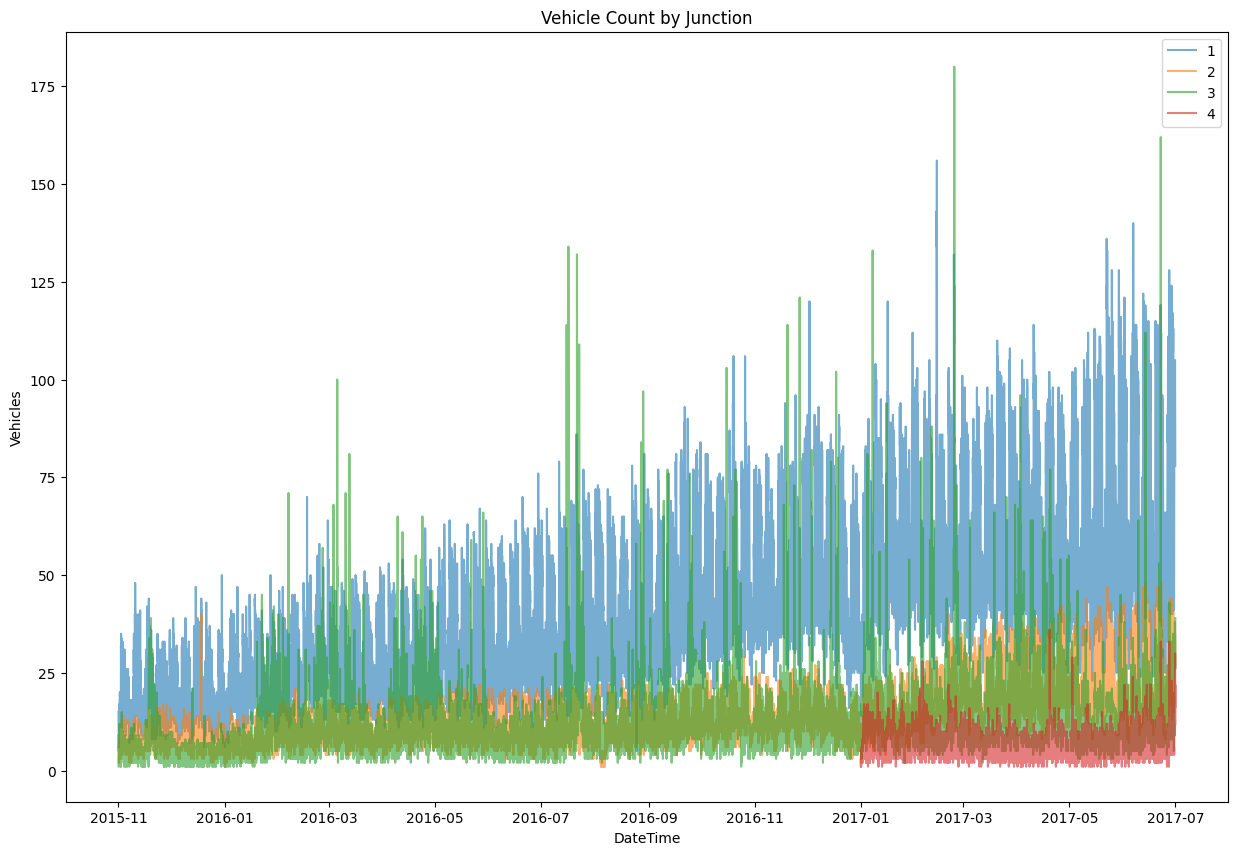

In [4]:
## NOW WE PLOT THE TIME-SERIES FROM THE 4 JUNCTIONS OVER ENTIRE TIMESPAN

def plot_junction(df, junction_id, range=None):
  df_int = df[ df['Junction'] == junction_id ]

  if range is not None:
    df_int = df_int[range[0]:range[1]]


  sns.lineplot(data=df_int, x='DateTime', y='Vehicles', style=junction_id, alpha=0.6)

plt.figure(figsize=(15, 10))
plot_junction(df, 1)
plot_junction(df, 2)
plot_junction(df, 3)
plot_junction(df, 4)
plt.title("Vehicle Count by Junction")
plt.show()

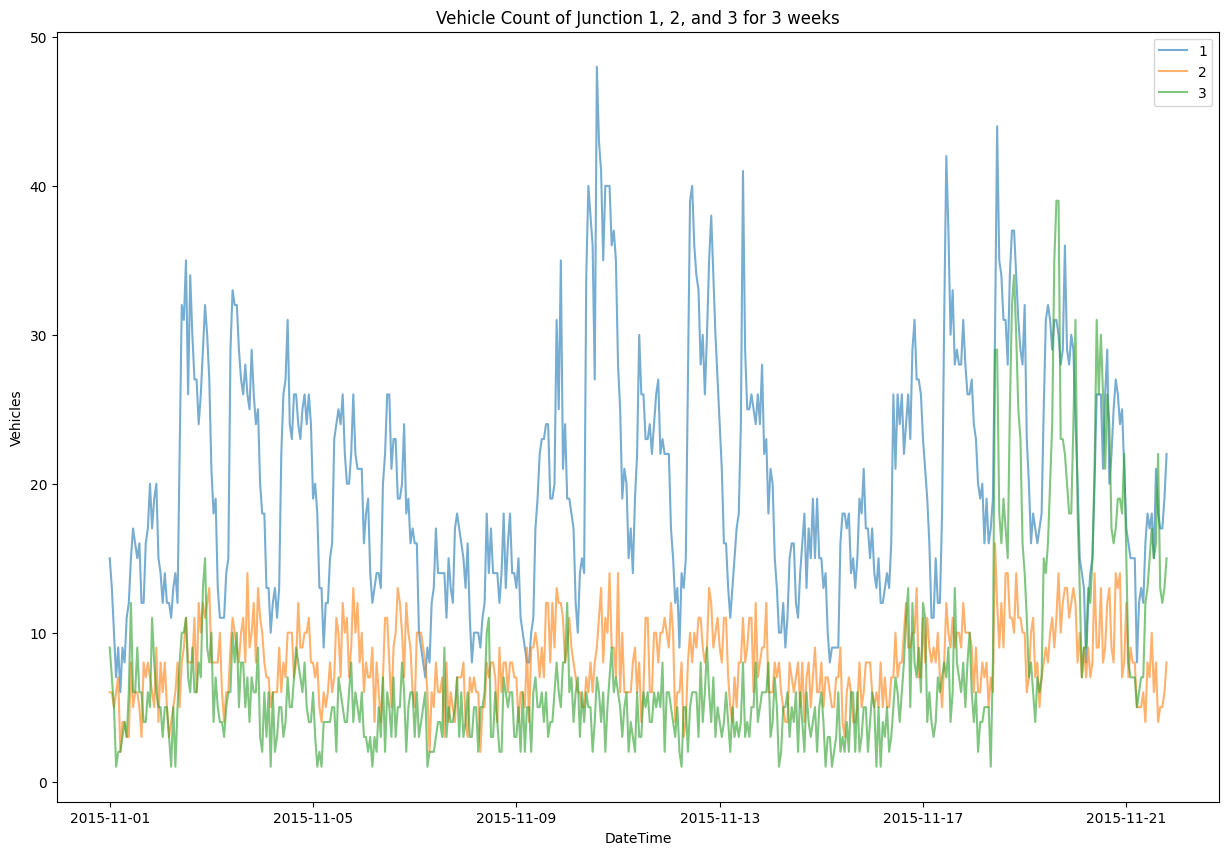

In [5]:
## WE SHOULD ALSO PLOT A SINGLE JUNCTION OVER A WEEKLY(ISH) SPAN

plt.figure(figsize=(15, 10))
plot_junction(df, 1, range=[0,500])
plot_junction(df, 2, range=[0,500])
plot_junction(df, 3, range=[0,500])
plt.title("Vehicle Count of Junction 1, 2, and 3 for 3 weeks")
plt.show()

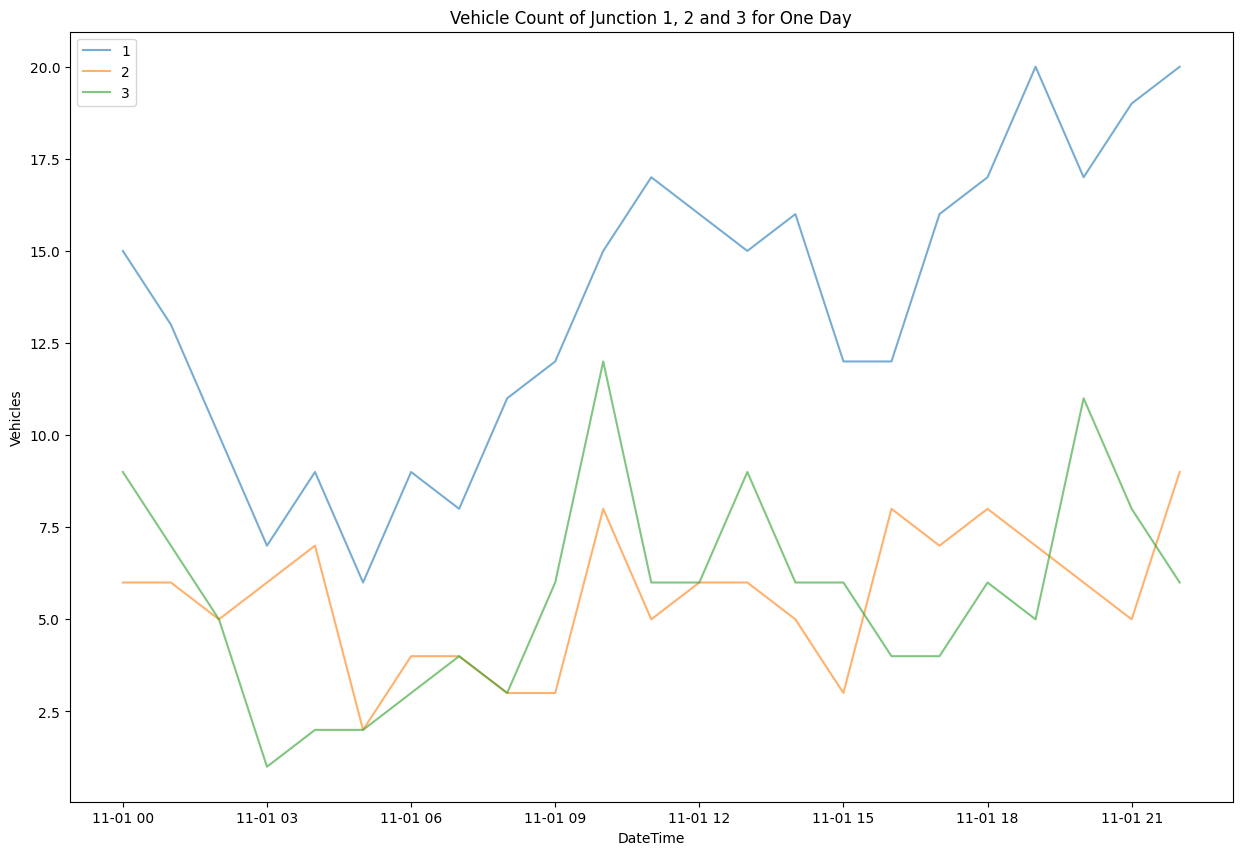

In [6]:
## WE SHOULD ALSO PLOT A SINGLE JUNCTION OVER A DAILY SPAN

plt.figure(figsize=(15, 10))
plot_junction(df, 1, range=[0,23])
plot_junction(df, 2, range=[0,23])
plot_junction(df, 3, range=[0,23])
plt.title("Vehicle Count of Junction 1, 2 and 3 for One Day")
plt.show()

## Dataset Metrics

Here we perform decomposition on all 4 junctions, aiming to see if traffic data as a whole has noticable things like a *strong trend*, *predictable seasonal periods*, and more.

After decomposition we can see that the common themes below:
- There *might* be a strong trend
- There is strong seasonality present in the data
- There is also a high level of noise

The trend might be very strong, or moderate this is evident due to junction 1, and 2 showing stronger trends, but junction 3 and 4 showing little to no trend over time. This might mean these roads are extremely far apart (highway vs random back-road)

The swing (magnitude) of the Residuals is also quite significant when compared to the overall swing of the other categories, this might mean it is better to apply some smoothing to the data to ease the noise a bit, as we do not need our model overfitting to the noise.

We also ran ADFuller Method to check if the data is stationary, it seems that it is, However since there is a clear seasonality this is not accurate. We might me able to benchmark our DL model against traditional statistical models like SARIMA afterwards to gauge the improvement (if any)

Decomposition of Junction 1...
	Standard Deviation of Residuals: 6.740624895032344
	ADFULLER - Junction 1:
	ADF Statistic: -7.1480776882871755
	p-value: 3.193842996353856e-10
	Result is Stationary
Decomposition of Junction 2...
	Standard Deviation of Residuals: 2.755961564263759
	ADFULLER - Junction 2:
	ADF Statistic: -8.041077275597736
	p-value: 1.846368366770321e-12
	Result is Stationary
Decomposition of Junction 3...
	Standard Deviation of Residuals: 6.502172147265137
	ADFULLER - Junction 3:
	ADF Statistic: -8.236600353699227
	p-value: 5.867295855827916e-13
	Result is Stationary
Decomposition of Junction 4...
	Standard Deviation of Residuals: 2.34484031733941
	ADFULLER - Junction 4:
	ADF Statistic: -6.726732196265544
	p-value: 3.3748745834489532e-09
	Result is Stationary


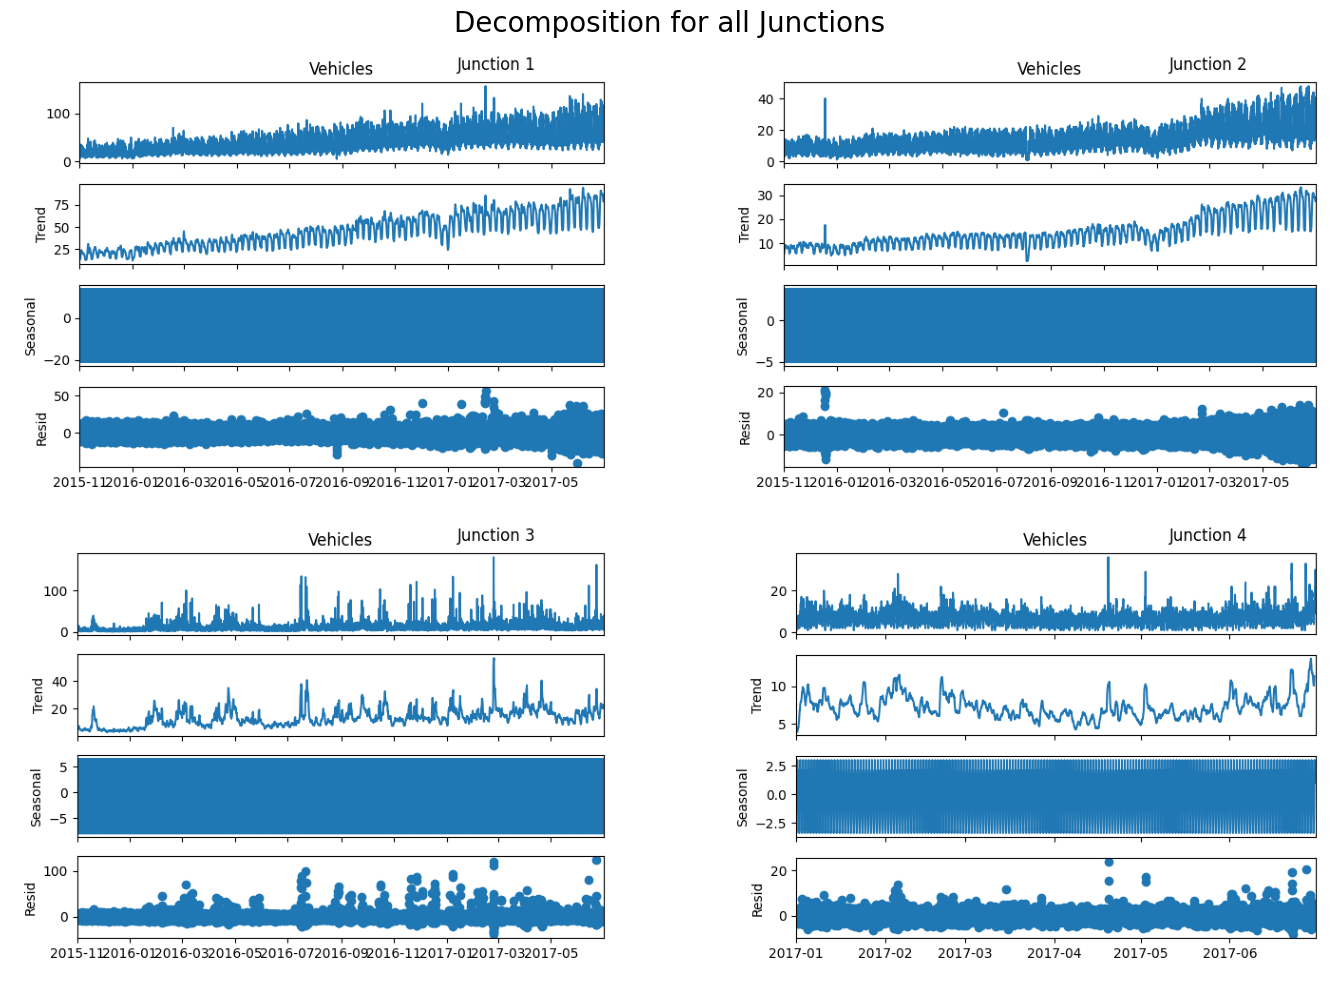

In [7]:
## HERE WE CAN USE STATSMODELS TO DECOMPOSE STUFF

def decompose_junction(df, junction_id, model='additive', period=24, col='Vehicles'):
  print(f"Decomposition of Junction {junction_id}...")
  df_int = df[ df['Junction'] == junction_id ]
  result = seasonal_decompose(df_int[col], model=model, period=period)
  # print out std devn of residuals as well
  print(f"\tStandard Deviation of Residuals: {result.resid.std()}")
  return result

def adfuller_junction(df, junction_id):
    df_int = df[ df['Junction'] == junction_id ]
    result = adfuller(df_int['Vehicles'])
    print(f"\tADFULLER - Junction {junction_id}:")
    print(f'\tADF Statistic: {result[0]}')
    print(f'\tp-value: {result[1]}')
    if (result[1] <= 0.05):
      print("\tResult is Stationary")
    else:
      print("\tResult is Non-Stationary")


# now we make a pretty 2x2 grid for everything :)
j_ids = [1,2,3,4]
fig, ax = plt.subplots(2,2, figsize=(15,10))

for ax, jid in zip(ax.flatten(), j_ids):
  r = decompose_junction(df, jid)
  adfuller_junction(df, jid)

  subfig = r.plot()
  subfig.suptitle(f"Junction {jid}", x=0.8, y=0.98)
  subfig.canvas.draw()

  ax.imshow(subfig.canvas.renderer.buffer_rgba())
  ax.set_axis_off()
  plt.close(subfig)

plt.suptitle("Decomposition for all Junctions", fontsize=20)
plt.tight_layout()
plt.show()

# Part 2 Data Preprocessing & Cleaning

In Part 1 we noticed that there are lots of things we can probably use to help our model learn the data more accurately.

From seasonal/trend decomposition, we can see that the magnitude of the components are quite low compared to the residuals, this is not ideal and this means we have a lot of *noise* in our data. Our model should not overfit to this noise, and thus we should employ some sort of smoothing algorithm to the data first in order to teach the model the general time dependency.

This section will compare the trend decomposition before/after smoothing, and we will also be performing data filling with some methods.

## Handling Missing Observations

In [8]:
## USING RAW DF LETS FIND OUT IF THERE ARE ANY MISSING ENTRIES
missing_total = df.isna().sum()
if (missing_total.sum() == 0):
  print("There are no missing values in this dataset")
else:
  print(missing_total)

## there aren't anny (thank god) so we dont gotta deal w this

There are no missing values in this dataset


## Data Smoothing

In order to pick an algorithm we should consider the nature of the dataset, this is traffic data, so we dont want an entirely smooth graph, and we also should weight the current observation much more heavily than previous ones.

Thus we can probably use some sort of decaying exponential over $n$ lags to smooth this out. Then we can decompose the smoothed series and examine the magnitude of the residuals.

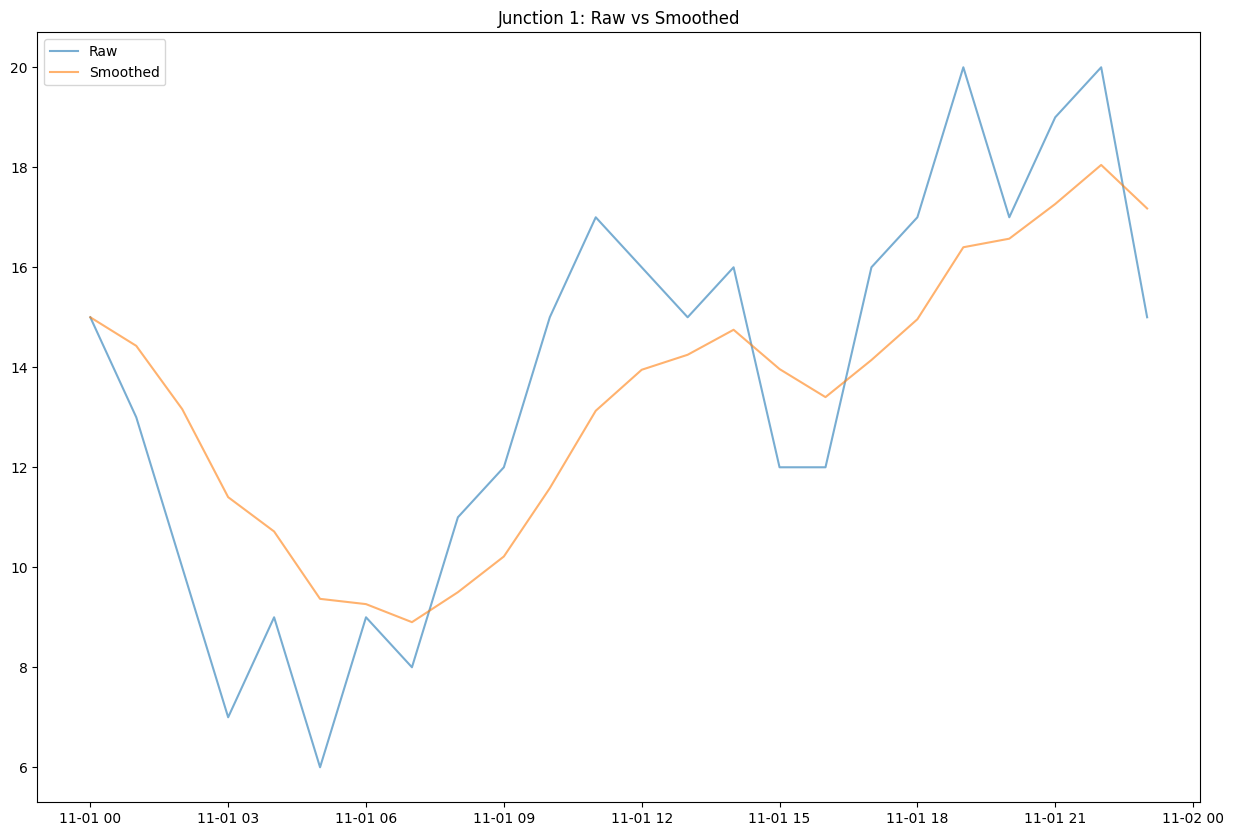

In [9]:
## CREATE A SMOOTHED SERIES for each junction separately

## create a new df for each junction (raw/smooth)
df1 = df[ df['Junction'] == 1 ].copy()
df2 = df[ df['Junction'] == 2 ].copy()
df3 = df[ df['Junction'] == 3 ].copy()
df4 = df[ df['Junction'] == 4 ].copy()


## use ewma with span of 6 hrs to smooth stuff
for dframe in [df1, df2, df3, df4]:
  dframe['Vehicles_Smooth'] = dframe['Vehicles'].ewm(span=6, adjust=False).mean()

## plot raw vs smoothed for Junction 1
plt.figure(figsize=(15,10))
plt.plot(df1['Vehicles'][0:24], label='Raw', alpha=0.6)
plt.plot(df1['Vehicles_Smooth'][0:24], label='Smoothed', alpha=0.6)
plt.title("Junction 1: Raw vs Smoothed")
plt.legend()
plt.show()


Decomposition of Junction 1...
	Standard Deviation of Residuals: 4.768430388809989
	ADFULLER - Junction 1:
	ADF Statistic: -7.1480776882871755
	p-value: 3.193842996353856e-10
	Result is Stationary
Decomposition of Junction 2...
	Standard Deviation of Residuals: 1.67853225417233
	ADFULLER - Junction 2:
	ADF Statistic: -8.041077275597736
	p-value: 1.846368366770321e-12
	Result is Stationary
Decomposition of Junction 3...
	Standard Deviation of Residuals: 3.8137424814344727
	ADFULLER - Junction 3:
	ADF Statistic: -8.236600353699227
	p-value: 5.867295855827916e-13
	Result is Stationary
Decomposition of Junction 4...
	Standard Deviation of Residuals: 1.1150059263457026
	ADFULLER - Junction 4:
	ADF Statistic: -6.726732196265544
	p-value: 3.3748745834489532e-09
	Result is Stationary


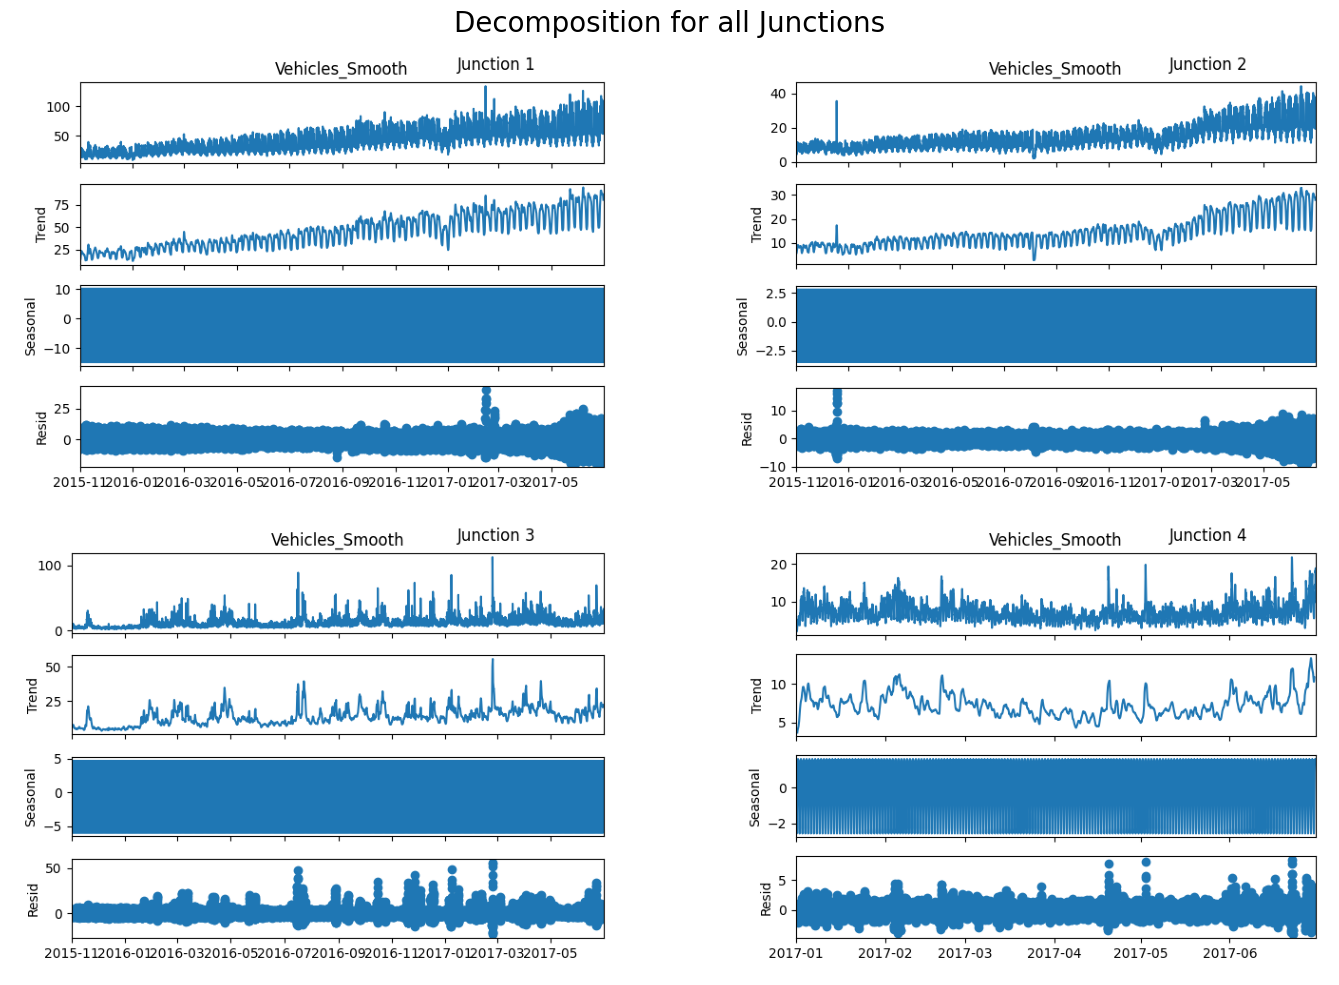

In [10]:
## PERFORM DECOMPOSITION AGAIN, now we can compare with the unsmoothed data to see if this is really worth it.

j_ids = [1,2,3,4]
dfs = [df1, df2, df3, df4]
fig, ax = plt.subplots(2,2, figsize=(15,10))

for ax, jid, dff in zip(ax.flatten(), j_ids, dfs):
  r = decompose_junction(dff, jid, col='Vehicles_Smooth')
  adfuller_junction(dff, jid)

  subfig = r.plot()
  subfig.suptitle(f"Junction {jid}", x=0.8, y=0.98)
  subfig.canvas.draw()

  ax.imshow(subfig.canvas.renderer.buffer_rgba())
  ax.set_axis_off()
  plt.close(subfig)

plt.suptitle("Decomposition for all Junctions", fontsize=20)
plt.tight_layout()
plt.show()

# from the std devn of residuals we can see they decreased by a lot (around 33%)


# Part 3: The Deep Learning Model

In [11]:
def sliding_window(data, window_length=4, forecast_length=1):
  X, y = [], []
  for i in range( len(data) - (window_length + forecast_length) + 1):
    X.append(data[i:i+window_length])
    y.append(data[i+window_length:i+window_length+forecast_length])
  return np.array(X), np.array(y)

## we can use junction 1, 2, 3 for training and can use junction 4 for testing

In [12]:
# use minmax scaler to scale stuff properly, we will be using df1 - df4 here

scalers    = {}
dfs_scaled = []

for i, df in enumerate([df1, df2, df3, df4], start=1):
  scaler = MinMaxScaler()
  df_scaled = scaler.fit_transform(df['Vehicles_Smooth'].values.reshape(-1,1))
  dfs_scaled.append(df_scaled)
  scalers[i] = scaler

In [13]:
## create windowed data to prepare for deep-learning

window_len = 6
pred_len   = 1

X_training_list = []
y_training_list = []
i = 1;
for df_scaled in dfs_scaled[0:3]:
  print(f"Preparing Junction {i} (Training)")
  i = i+1
  X, y = sliding_window(df_scaled, window_length=window_len, forecast_length=pred_len)
  X_training_list.append(X)
  y_training_list.append(y)

## combine junctions 1-3 into training set
X_train = np.concatenate(X_training_list, axis=0)
y_train = np.concatenate(y_training_list, axis=0)

## do the same for training set (junction 4)
print(f"Preparing Junction 4 (Testing)")
X_test, y_test = sliding_window(dfs_scaled[3], window_length=window_len, forecast_length=pred_len)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Preparing Junction 1 (Training)
Preparing Junction 2 (Training)
Preparing Junction 3 (Training)
Preparing Junction 4 (Testing)


In [20]:
##### DEFINE THE ENSEMBLE MODEL ARCHITECTURE


def ensemble_model(hp):
  # input layer will be of size (window length x num_features) here we onnly have 1 feature
  input_seq = Input(shape=(window_len, 1))

  # use an LSTM to capture general trend of the data
  lstm_1   = LSTM(hp.Choice("lstm1_size", values=[16,32,86]), activation='tanh', return_sequences=True)(input_seq)
  lstm_2   = LSTM(hp.Choice("lstm2_size", values=[8,16,32]), activation='tanh', return_sequences=False)(lstm_1)
  lstm_out = Dense(pred_len)(lstm_2)

  # use a 1D-CNN to capture local trends/seasonality patterns
  cnn_1     = Conv1D(32, kernel_size=hp.Choice("kernel_size", values=[2,6,8]), activation='relu', padding='causal')(input_seq)
  cnn_pool  = GlobalMaxPool1D()(cnn_1)
  cnn_out   = Dense(pred_len)(cnn_pool)

  # can use a basic NN to learn to combine the predictions
  cat = Concatenate()([lstm_out, cnn_out])
  nn  = Dense(16, activation='relu')(cat)
  out  = Dense(pred_len, activation='linear')(cat)

  # create/compile the model
  model = tf.keras.Model(inputs=input_seq, outputs=out)
  model.compile(optimizer='adam', loss='mse', metrics=['mse'])
  return model


In [21]:
! rm -rf ./gs_logs/

In [22]:
tuner = kt.GridSearch(
    hypermodel=ensemble_model,
    objective='val_mse',
    directory="gs_logs",
    project_name="gridsearch"
)

tuner.search(
    X_train, y_train,
    epochs=4,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Trial 27 Complete [00h 00m 24s]
val_mse: 0.00043545785592868924

Best val_mse So Far: 0.00033195444848388433
Total elapsed time: 00h 11m 04s


In [23]:
### get best model n train it some more

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = ensemble_model(best_hps)
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
    )

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 6, 32)     │      4,352 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 6, 32)     │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │      8,320 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2)         │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │          3 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,965 (50.64 KB)

 Trainable params: 12,965 (50.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 5.9832e-04 - val_mse: 5.9832e-04
Epoch 2/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 3.3051e-04 - mse: 3.3051e-04 - val_loss: 4.7358e-04 - val_mse: 4.7358e-04
Epoch 3/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.5500e-04 - mse: 2.5500e-04 - val_loss: 4.4779e-04 - val_mse: 4.4779e-04
Epoch 4/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.2000e-04 - mse: 2.2000e-04 - val_loss: 3.8728e-04 - val_mse: 3.8728e-04
Epoch 5/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.0498e-04 - mse: 2.0498e-04 - val_loss: 3.6311e-04 - val_mse: 3.6311e-04
Epoch 6/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.9525e-04 - mse: 1.9525e-04 - val_loss: 3.4770e-04 - val_mse: 3.4770e-04
Epoch 7/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.8721e-04 - mse: 1.8721e-04 - val_loss: 3.3896e-04 - val_mse: 3.3896e-04
Epoch 8/8
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


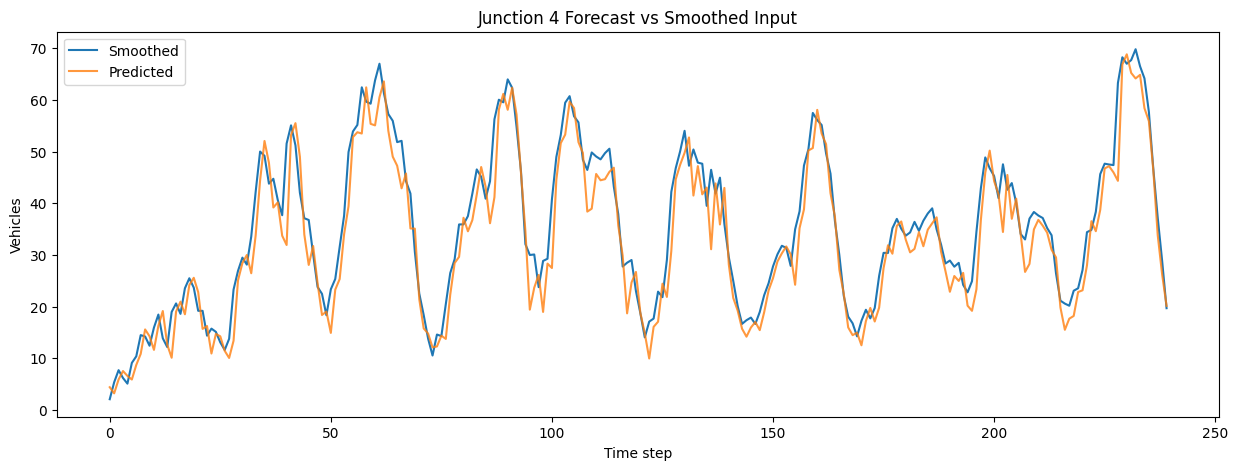

MSE: 24.882588287792753
MAE: 3.74827668889107


In [24]:
## EVALUATE NEXT HOUR FORECASTING

# now after 12903801283 years our model is trained, we can use it to predict junction 4
y_preds_scaled = model.predict(X_test)

# remove 3rd dimension
y_preds_2d = y_preds_scaled.reshape(-1, 1)
y_true_2d  = y_test.reshape(-1, 1)

# unscale
s = scalers[3]
y_pred = s.inverse_transform(y_preds_2d)
y_true = s.inverse_transform(y_true_2d)

# plot
max_range = 240

plt.figure(figsize=(15,5))
plt.plot(y_true.flatten()[0:max_range], label='Smoothed') # note that we are plotting against the smoothed input series
plt.plot(y_pred.flatten()[0:max_range], label='Predicted', alpha=0.8)
plt.title("Junction 4 Forecast vs Smoothed Input")
plt.xlabel("Time step")
plt.ylabel("Vehicles")
plt.legend()
plt.show()

## print metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f"MSE: {mean_squared_error(y_true, y_pred)}")
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
